<a href="https://colab.research.google.com/github/Anurag131277/langchain/blob/main/langchain_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --quiet -U langgraph langchain_community langchain_core tavily-python langchain_nvidia_ai_endpoints

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
import os

In [ ]:
nvapi_key = userdata.get('NVIDIA_API_KEY')
assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
os.environ["NVIDIA_API_KEY"] = nvapi_key

In [ ]:
os.environ["LANGCHAIN_API_KEY"]= userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "default"
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [ ]:
from tavily import TavilyClient, AsyncTavilyClient
tavily_client = TavilyClient()
tavily_async_client = AsyncTavilyClient()

In [ ]:

## Core LC Chat Interface
from langchain_nvidia_ai_endpoints import ChatNVIDIA

In [ ]:
llm = ChatNVIDIA(model="meta/llama-3.3-70b-instruct", temperature=0)
result = llm.invoke("Write a ballad about LangChain.")
print(result.content)

(Verse 1)
In realms of code, where innovators roam
A new dawn broke, with LangChain's noble tone
A framework born, to harness language's might
To build and create, through day and endless night

(Chorus)
Oh LangChain, oh LangChain, a beacon in the land
Guiding developers, hand in hand
With LLMs and APIs, a harmonious blend
Building applications, that never end

(Verse 2)
From text to image, to conversation's flow
LangChain weaves, a tapestry to know
The power of AI, at the developer's command
A symphony of code, at their fingertips to stand

(Chorus)
Oh LangChain, oh LangChain, a beacon in the land
Guiding developers, hand in hand
With LLMs and APIs, a harmonious blend
Building applications, that never end

(Verse 3)
Through agents and tools, the framework shines so bright
Aiding humans, in their creative plight
From simple tasks, to complex designs
LangChain empowers, the innovative minds

(Chorus)
Oh LangChain, oh LangChain, a beacon in the land
Guiding developers, hand in hand
With 

In [ ]:
import asyncio
from langsmith import traceable
from pydantic import BaseModel, Field

from typing_extensions import TypedDict
from typing import  Annotated, List, Optional, Literal

class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    research: bool = Field(
        description="Whether to perform web research for this section of the report."
    )
    content: str = Field(
        description="The content of the section."
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )
class SearchQuery(BaseModel):
    search_query: str = Field(
        None, description="Query for web search."
    )
class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.

    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results

    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")

    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source

    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"

    return formatted_text.strip()


def format_sections(sections: list[Section]) -> str:
    """ Format a list of sections into a string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description:
{section.description}
Requires Research:
{section.research}

Content:
{section.content if section.content else '[Not yet written]'}

"""
    return formatted_str


@traceable
def tavily_search(query):
    """ Search the web using the Tavily API.

    Args:
        query (str): The search query to execute

    Returns:
        dict: Tavily search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str): Full content of the page if available"""

    return tavily_client.search(query,
                         max_results=5,
                         include_raw_content=True)

@traceable
async def tavily_search_async(search_queries, tavily_topic, tavily_days):
    """
    Performs concurrent web searches using the Tavily API.

    Args:
        search_queries (List[SearchQuery]): List of search queries to process
        tavily_topic (str): Type of search to perform ('news' or 'general')
        tavily_days (int): Number of days to look back for news articles (only used when tavily_topic='news')

    Returns:
        List[dict]: List of search results from Tavily API, one per query

    Note:
        For news searches, each result will include articles from the last `tavily_days` days.
        For general searches, the time range is unrestricted.
    """

    search_tasks = []
    for query in search_queries:
        if tavily_topic == "news":
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="news",
                    days=tavily_days
                )
            )
        else:
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="general"
                )
            )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    return search_docs


In [ ]:
import operator
#langgraph state report
class ReportState(TypedDict):
    topic: str # Report topic
    tavily_topic: Literal["general", "news"] # Tavily search topic
    tavily_days: Optional[int] # Only applicable for news topic
    report_structure: str # Report structure
    number_of_queries: int # Number web search queries to perform per section
    sections: list[Section] # List of report sections
    completed_sections: Annotated[list, operator.add] # Send() API key
    report_sections_from_research: str # String of any completed sections from research to write final sections
    final_report: str # Final report

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

In [ ]:
# Prompt to generate a search query to help with planning the report outline
report_planner_query_writer_instructions="""You are an expert technical writer, helping to plan a report.

The report will be focused on the following topic:

{topic}

The report structure will follow these guidelines:

{report_organization}

Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information for planning the report sections.

The query should:

1. Be related to the topic
2. Help satisfy the requirements specified in the report organization

Make the query specific enough to find high-quality, relevant sources while covering the breadth needed for the report structure."""


# Prompt generating the report outline
report_planner_instructions="""You are an expert technical writer, helping to plan a report.

Your goal is to generate the outline of the sections of the report.

The overall topic of the report is:

{topic}

The report should follow this organization:

{report_organization}

You should reflect on this information to plan the sections of the report:

{context}

Now, generate the sections of the report. Each section should have the following fields:

- Name - Name for this section of the report.
- Description - Brief overview of the main topics and concepts to be covered in this section.
- Research - Whether to perform web research for this section of the report.
- Content - The content of the section, which you will leave blank for now.

Consider which sections require web research. For example, introduction and conclusion will not require research because they will distill information from other parts of the report."""




In [ ]:

async def generate_report_plan(state: ReportState):

    # Inputs
    topic = state["topic"]
    report_structure = state["report_structure"]
    number_of_queries = state["number_of_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days", None)

    # Convert JSON object to string if necessary
    if isinstance(report_structure, dict):
        report_structure = str(report_structure)

    # Generate search query
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=report_structure, number_of_queries=number_of_queries)

    # Generate queries
    results = structured_llm.invoke([SystemMessage(content=system_instructions_query)]+[HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])

    # Web search
    query_list = [query.search_query for query in results.queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=1000, include_raw_content=True)

    # Format system instructions
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str)

    # Generate sections
    structured_llm = llm.with_structured_output(Sections)
    report_sections = structured_llm.invoke([SystemMessage(content=system_instructions_sections)]+[HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")])

    return {"sections": report_sections.sections}

In [ ]:
# Structure
report_structure = """This report type focuses on comparative analysis.

The report structure should include:
1. Introduction (no research needed)
   - Brief overview of the topic area
   - Context for the comparison

2. Main Body Sections:
   - One dedicated section for EACH offering being compared in the user-provided list
   - Each section should examine:
     - Core Features (bulleted list)
     - Architecture & Implementation (2-3 sentences)
     - One example use case (2-3 sentences)

3. No Main Body Sections other than the ones dedicated to each offering in the user-provided list

4. Conclusion with Comparison Table (no research needed)
   - Structured comparison table that:
     * Compares all offerings from the user-provided list across key dimensions
     * Highlights relative strengths and weaknesses
   - Final recommendations"""

In [ ]:
# Topic
# report_topic = "Give an overview of capabilities and specific use case examples for these processing units: CPU, GPU."
report_topic = "Give an overview of The Importance of Recycling"

In [ ]:
# Tavily search parameters
tavily_topic = "general"
tavily_days = None # Only applicable for news topic

# Generate report plan
sections = await generate_report_plan({"topic": report_topic, "report_structure": report_structure, "number_of_queries": 2, "tavily_topic": tavily_topic, "tavily_days": tavily_days})

# Print sections
for section in sections['sections']:
    print(f"{'='*50}")
    print(f"Name: {section.name}")
    print(f"Description: {section.description}")
    print(f"Research: {section.research}")

Name: Introduction
Description: Provide a brief overview of the topic area and context for the comparison between CPU and GPU processing units.
Research: False
Name: CPU
Description: Examine the core features, architecture, and implementation of CPU processing units, and provide an example use case.
Research: True
Name: GPU
Description: Examine the core features, architecture, and implementation of GPU processing units, and provide an example use case.
Research: True
Name: Conclusion with Comparison Table
Description: Present a structured comparison table highlighting the relative strengths and weaknesses of CPU and GPU processing units, and provide final recommendations.
Research: False


In [ ]:
class SectionState(TypedDict):
    tavily_topic: Literal["general", "news"] # Tavily search topic
    tavily_days: Optional[int] # Only applicable for news topic
    number_of_queries: int # Number web search queries to perform per section
    section: Section # Report section
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # String of any completed sections from research to write final sections
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

In [ ]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph

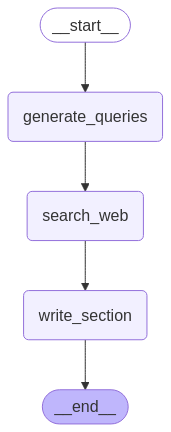

In [ ]:

# Query writer instructions
query_writer_instructions="""Your goal is to generate targeted web search queries that will gather comprehensive information for writing a technical report section.

Topic for this section:
{section_topic}

When generating {number_of_queries} search queries, ensure they:
1. Cover different aspects of the topic (e.g., core features, real-world applications, technical architecture)
2. Include specific technical terms related to the topic
3. Target recent information by including year markers where relevant (e.g., "2024")
4. Look for comparisons or differentiators from similar technologies/approaches
5. Search for both official documentation and practical implementation examples

Your queries should be:
- Specific enough to avoid generic results
- Technical enough to capture detailed implementation information
- Diverse enough to cover all aspects of the section plan
- Focused on authoritative sources (documentation, technical blogs, academic papers)"""

# Section writer instructions
section_writer_instructions = """You are an expert technical writer crafting one section of a technical report.

Topic for this section:
{section_topic}

Guidelines for writing:

1. Technical Accuracy:
- Include specific version numbers
- Reference concrete metrics/benchmarks
- Cite official documentation
- Use technical terminology precisely

2. Length and Style:
- Strict 150-200 word limit
- No marketing language
- Technical focus
- Write in simple, clear language
- Start with your most important insight in **bold**
- Use short paragraphs (2-3 sentences max)

3. Structure:
- Use ## for section title (Markdown format)
- Only use ONE structural element IF it helps clarify your point:
  * Either a focused table comparing 2-3 key items (using Markdown table syntax)
  * Or a short list (3-5 items) using proper Markdown list syntax:
    - Use `*` or `-` for unordered lists
    - Use `1.` for ordered lists
    - Ensure proper indentation and spacing
- End with ### Sources that references the below source material formatted as:
  * List each source with title, date, and URL
  * Format: `- Title : URL`

3. Writing Approach:
- Include at least one specific example or case study
- Use concrete details over general statements
- Make every word count
- No preamble prior to creating the section content
- Focus on your single most important point

4. Use this source material to help write the section:
{context}

5. Quality Checks:
- Exactly 150-200 words (excluding title and sources)
- Careful use of only ONE structural element (table or list) and only if it helps clarify your point
- One specific example / case study
- Starts with bold insight
- No preamble prior to creating the section content
- Sources cited at end"""

def generate_queries(state: SectionState):
    """ Generate search queries for a section """

    # Get state
    number_of_queries = state["number_of_queries"]
    section = state["section"]

    # Generate queries
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(section_topic=section.description, number_of_queries=number_of_queries)

    # Generate queries
    queries = structured_llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

async def search_web(state: SectionState):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""

    # Get state
    search_queries = state["search_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days", None)

    # Web search
    query_list = [query.search_query for query in search_queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=5000, include_raw_content=True)

    return {"source_str": source_str}

def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state
    section = state["section"]
    source_str = state["source_str"]

    # Format system instructions
    system_instructions = section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=source_str)

    # Generate section
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])

    # Write content to the section object
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

# Add nodes and edges
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)

# Compile
section_builder_graph = section_builder.compile()

# View
display(Image(section_builder_graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Test with one section
sections = sections['sections']
test_section = sections[1]
print(f"{'='*50}")
print(f"Name: {test_section.name}")
print(f"Description: {test_section.description}")
print(f"Research: {test_section.research}")

# Run
report_section = await section_builder_graph.ainvoke({"section": test_section, "number_of_queries": 2, "tavily_topic": tavily_topic, "tavily_days": tavily_days})

Name: CPU
Description: Examine the core features, architecture, and implementation of CPU processing units, and provide an example use case.
Research: True


In [ ]:
print(report_section)

{'completed_sections': [Section(name='CPU', description='Examine the core features, architecture, and implementation of CPU processing units, and provide an example use case.', research=True, content="## Core Features and Architecture of CPU Processing Units\n**The core architecture of CPU processing units has undergone significant transformations in recent years**, with a focus on improving performance, power efficiency, and scalability. The Armv9.2 architecture, for example, introduces enhanced security features such as memory tagging extensions (MTE) and confidential compute architecture (CCA). A specific example of this is the Arm Cortex X925 core, which promises substantial performance improvements, especially in single-threaded workloads. \n- Key features of modern CPU architectures include:\n  - Modular tile-based layouts\n  - Hybrid structures combining performance and efficiency cores\n  - Advanced packaging technologies like Foveros 3D packaging\n  - Enhanced security feature

In [ ]:
from IPython.display import Markdown
section = report_section['completed_sections'][0]
Markdown(section.content)

## Core Features and Architecture of CPU Processing Units
**The core architecture of CPU processing units has undergone significant transformations in recent years**, with a focus on improving performance, power efficiency, and scalability. The Armv9.2 architecture, for example, introduces enhanced security features such as memory tagging extensions (MTE) and confidential compute architecture (CCA). A specific example of this is the Arm Cortex X925 core, which promises substantial performance improvements, especially in single-threaded workloads. 
- Key features of modern CPU architectures include:
  - Modular tile-based layouts
  - Hybrid structures combining performance and efficiency cores
  - Advanced packaging technologies like Foveros 3D packaging
  - Enhanced security features and AI optimizations
The combination of these features enables CPU processing units to deliver unprecedented performance gains, improved power efficiency, and increased scalability, making them suitable for a wide range of applications, from mobile devices to datacenter servers.
### Sources
- Arm Unveils 2024 CPU Core Designs, Cortex X925, A725 and A520: Arm v9.2 Redefined For 3nm - AnandTech: https://www.anandtech.com/show/21399/arm-unveils-2024-cpu-core-designs-cortex-x925-a725-and-a520-arm-v9-2-redefined-for-3nm- 
- A Look at 2024's New CPU Models: Powering the Next Generation of Computing - Medium: https://medium.com/@nabeelfaraz/a-look-at-2024s-new-cpu-models-powering-the-next-generation-of-computing-8d4d394e7531 
- 2024 Intel Tech Tour: Next Gen P-core-The Lion Cove Microarchitecture - Intel: https://www.intel.com/content/www/us/en/content-details/824430/2024-intel-tech-tour-next-gen-p-core-the-lion-cove-microarchitecture.html 
- The evolution of CPUs: what's next? - TechFinitive: https://www.techfinitive.com/features/the-evolution-of-cpus-whats-next/ 
- 4th Gen AMD EPYC Processor Architecture Whitepaper - AMD: https://www.amd.com/content/dam/amd/en/documents/products/epyc/4th-gen-amd-epyc-processor-architecture-whitepaper.pdf 
- Analyzing AMD's Next-Generation CPU, GPU And DPU - Forbes: https://www.forbes.com/sites/moorinsights/2024/10/14/analyzing-amds-next-generation-cpu-gpu-and-dpu/ 
- CPU vs. GPU: What's the Difference? - UMA Technology: https://umatechnology.org/cpu-vs-gpu-whats-the-difference/ 
- GPU vs CPU: A pair of good brothers who support each other - Geekom: https://www.geekompc.com/gpu-vs-cpu/ 
- CPU vs GPU: We tested 16 hardware combinations to show which upgrade will boost your gaming performance the most - Tom's Hardware: https://www.tomshardware.com/pc-components/gpus/cpu-vs-gpu-upgrade-benchmarks-testing 
- AI Hardware Showdown: CPU vs GPU vs NPU - Harrison Clarke: https://www.harrisonclarke.com/blog/ai-hardware-showdown-cpu-vs-gpu-vs-npu/

In [ ]:
#write all sections
class ReportStateOutput(TypedDict):
    final_report: str # Final report

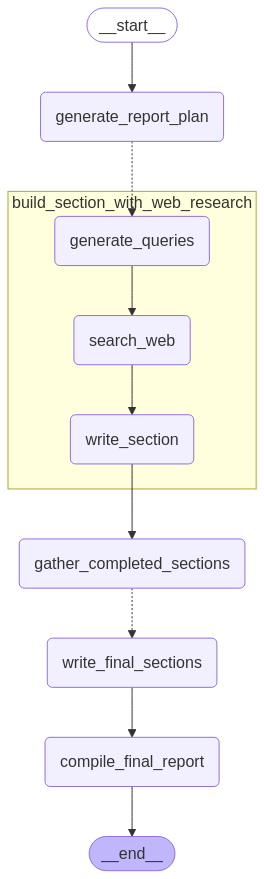

In [ ]:
from langgraph.constants import Send

final_section_writer_instructions="""You are an expert technical writer crafting a section that synthesizes information from the rest of the report.

Section to write:
{section_topic}

Available report content:
{context}

1. Section-Specific Approach:

For Introduction:
- Use # for report title (Markdown format)
- 50-100 word limit
- Write in simple and clear language
- Focus on the core motivation for the report in 1-2 paragraphs
- Use a clear narrative arc to introduce the report
- Include NO structural elements (no lists or tables)
- No sources section needed

For Conclusion/Summary:
- Use ## for section title (Markdown format)
- 100-150 word limit
- For comparative reports:
    * Must include a focused comparison table using Markdown table syntax
    * Table should distill insights from the report
    * Keep table entries clear and concise
- For non-comparative reports:
    * Only use ONE structural element IF it helps distill the points made in the report:
    * Either a focused table comparing items present in the report (using Markdown table syntax)
    * Or a short list using proper Markdown list syntax:
      - Use `*` or `-` for unordered lists
      - Use `1.` for ordered lists
      - Ensure proper indentation and spacing
- End with specific next steps or implications
- No sources section needed

3. Writing Approach:
- Use concrete details over general statements
- Make every word count
- Focus on your single most important point

4. Quality Checks:
- For introduction: 50-100 word limit, # for report title, no structural elements, no sources section
- For conclusion: 100-150 word limit, ## for section title, only ONE structural element at most, no sources section
- Markdown format
- Do not include word count or any preamble in your response"""

def initiate_section_writing(state: ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report """

    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("build_section_with_web_research", {"section": s,
                                                 "number_of_queries": state["number_of_queries"],
                                                 "tavily_topic": state["tavily_topic"],
                                                 "tavily_days": state.get("tavily_days", None)})
        for s in state["sections"]
        if s.research
    ]

def write_final_sections(state: SectionState):
    """ Write final sections of the report, which do not require web search and use the completed sections as context """

    # Get state
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]

    # Format system instructions
    system_instructions = final_section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=completed_report_sections)

    # Generate section
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])

    # Write content to section
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

def gather_completed_sections(state: ReportState):
    """ Gather completed sections from research """

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}

def initiate_final_section_writing(state: ReportState):
    """ This is the "map" step when we kick off research on any sections that require it using the Send API """

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections", {"section": s, "report_sections_from_research": state["report_sections_from_research"]})
        for s in state["sections"]
        if not s.research
    ]

def compile_final_report(state: ReportState):
    """ Compile the final report """

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"final_report": all_sections}

# Add nodes and edges
builder = StateGraph(ReportState, output=ReportStateOutput)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("build_section_with_web_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)
builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan", initiate_section_writing, ["build_section_with_web_research"])
builder.add_edge("build_section_with_web_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

graph = builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Structure
report_structure = """This report type focuses on comparative analysis.

The report structure should include:
1. Introduction (no research needed)
   - Brief overview of the topic area
   - Context for the comparison

2. Main Body Sections:
   - One dedicated section for EACH offering being compared in the user-provided list
   - Each section should examine:
     - Core Features (bulleted list)
     - Architecture & Implementation (2-3 sentences)
     - One example use case (2-3 sentences)

3. No Main Body Sections other than the ones dedicated to each offering in the user-provided list

4. Conclusion with Comparison Table (no research needed)
   - Structured comparison table that:
     * Compares all offerings from the user-provided list across key dimensions
     * Highlights relative strengths and weaknesses
   - Final recommendations"""

# Tavily search parameters
tavily_topic = "general"
tavily_days = None # Only applicable for news topic

In [ ]:
# Topic
report_topic = "Give an overview of capabilities and specific use case examples for these processing units: CPU, GPU."

In [ ]:
report = await graph.ainvoke({"topic": report_topic,
                                   "report_structure": report_structure,
                                   "number_of_queries": 2,
                                   "tavily_topic": tavily_topic,
                                   "tavily_days": tavily_days})

In [ ]:
from IPython.display import Markdown
Markdown(report['final_report'])

# Overview of CPU and GPU Comparison
The topic area of CPU and GPU comparison is driven by the need for improved performance, power efficiency, and specialized functionality in computing. 

## Context for Comparison
The latest CPU models boast impressive performance and modern architectures, while GPUs are designed for compute-intensive tasks like AI training and machine learning, making a comparison between the two essential for understanding their strengths and weaknesses. 
| Component | Key Features | Benefits |
| --- | --- | --- |
| CPU | Modular tile-based design, Foveros 3D packaging technology | Improved flexibility, enhanced power efficiency |
| GPU | Massively parallel architecture, high-bandwidth memory | Exceptional performance for AI workloads, ideal for parallel processing |
Next steps involve exploring specific use cases where CPUs and GPUs are utilized, and implications for future computing architectures.

## CPU Architecture and Implementation
**The core architecture of modern CPUs is undergoing a significant transformation**, driven by the need for improved performance, power efficiency, and specialized functionality. The latest CPU models from Intel, AMD, and Apple boast impressive performance, enhanced energy efficiency, and modern architectures designed to cater to a wide range of applications. For instance, Intel's 14th generation Meteor Lake processors employ a modular tile-based design, where the CPU, GPU, and I/O components are separated into distinct chiplets, linked through Intel's Foveros 3D packaging technology. This design enhances flexibility, allowing for the combination of different tiles for specific performance needs and power efficiency. 
- Key features: modular tile-based design, Foveros 3D packaging technology
- Benefits: improved flexibility, enhanced power efficiency
### Sources
- A Look at 2024's New CPU Models: Powering the Next Generation of Computing | by NABEEL FARAZ | Medium: https://medium.com/@nabeelfaraz/a-look-at-2024s-new-cpu-models-powering-the-next-generation-of-computing-8d4d394e7531
- Arm Unveils 2024 CPU Core Designs, Cortex X925, A725 and A520: Arm v9.2 Redefined For 3nm | AnandTech: https://www.anandtech.com/show/21399/arm-unveils-2024-cpu-core-designs-cortex-x925-a725-and-a520-arm-v9-2-redefined-for-3nm-

## Core Features and Architecture of GPU
**The core features of a GPU, including its massively parallel architecture and high-bandwidth memory, make it an essential component for compute-intensive tasks like AI training and machine learning.** The GPU's architecture is designed to handle a large number of threads simultaneously, making it ideal for tasks that require parallel processing. For example, NVIDIA's Ampere architecture features up to 10,752 CUDA cores, providing exceptional performance for AI workloads. A specific example of GPU's capability is the NVIDIA Blackwell GB200 NVL72 cluster, which integrates 36 GB200 Superchips and delivers up to 30 times faster real-time trillion-parameter large language model (LLM) inference compared to previous generations.
### Sources
- GPU Architecture Explained: Key Components, Evolution & Performance: https://cloudmorpho.com/gpu/gpu-architecture/
- Understanding the architecture of a GPU: https://medium.com/codex/understanding-the-architecture-of-a-gpu-d5d2d2e8978b
- NVIDIA Blackwell GPUs: Architecture, Features, Specs: https://www.nexgencloud.com/blog/performance-benchmarks/nvidia-blackwell-gpus-architecture-features-specs

# Comparative Analysis of CPU and GPU
## Conclusion and Recommendations
The CPU and GPU have distinct architectures and implementations, catering to different performance needs. 
| Component | Architecture | Benefits | Example Use Case |
| --- | --- | --- | --- |
| CPU | Modular tile-based design, Foveros 3D packaging technology | Improved flexibility, enhanced power efficiency | Intel's 14th generation Meteor Lake processors |
| GPU | Massively parallel architecture, high-bandwidth memory | Exceptional performance for AI workloads, parallel processing | NVIDIA's Ampere architecture, Blackwell GB200 NVL72 cluster |
Based on the comparison, CPUs are suitable for general computing tasks, while GPUs excel in compute-intensive tasks like AI training and machine learning. Next steps involve selecting the appropriate component based on specific application requirements.